## Problem description
The goal of this project is to develop an image classification model to detect cancerous cells in histopathologic samples. This is a computer vision problem applied to medicine, aiming to assist in early cancer detection through automated image analysis.

##### Project Objectives

- Train and compare different convolutional neural network (CNN) architectures for binary classification.

- Evaluate model performance using AUC and other metrics like Accuracy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
%matplotlib inline

## Data description
The data is donwloaded from https://www.kaggle.com/competitions/histopathologic-cancer-detection/data competition. It is composed by the following files and folders:
- Test folder: This contains the images to classify for the challenge
- Train folder: This contains the images to train the model
- sample_submission.csv: Is the file as example of the sumbission that we need to upload
- tran_labels.csv: The file containing the label for each image in the training folder

Let's explore each of them:

In [2]:
train_labels = pd.read_csv('histo_data/train_labels.csv')
print(train_labels.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


In [3]:
print('Train shape:')
print(train_labels.shape)

Train shape:
(220025, 2)


The train dataset is composed for 220K samples, let's see if we have duplicated id's

In [4]:
len(train_labels['id'].unique())

220025

In [11]:
# Now let's explore the test folder
from pathlib import Path

folder_path = Path("histo_data/test")

test_ids = []

for f in folder_path.iterdir():
    if f.is_file():
        test_ids.append(f.name)

In [12]:
print('Test shape:')
print(len(test_ids))
print('Test unique ids (Check for duplicates)')
print(len(np.unique(test_ids)))

Test shape:
57458
Test unique ids (Check for duplicates)
57458


In [13]:
sample_submission = pd.read_csv('histo_data/sample_submission.csv')
sample_submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [14]:
print('Sample submission shape:')
print(sample_submission.shape)

Sample submission shape:
(57458, 2)


We can see that the sample submission and the test data is the same lenght, which makes sense.

In [15]:
test_ids[0:10]

['00006537328c33e284c973d7b39d340809f7271b.tif',
 '0000ec92553fda4ce39889f9226ace43cae3364e.tif',
 '00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif',
 '000253dfaa0be9d0d100283b22284ab2f6b643f6.tif',
 '000270442cc15af719583a8172c87cd2bd9c7746.tif',
 '000309e669fa3b18fb0ed6a253a2850cce751a95.tif',
 '000360e0d8358db520b5c7564ac70c5706a0beb0.tif',
 '00040095a4a671280aeb66cb0c9231e6216633b5.tif',
 '000698b7df308d75ec9559ef473a588c513a68aa.tif',
 '0006e1af5670323331d09880924381d67d79eda0.tif']

Also, as we can see the format of images is tif, let's explore few of them:

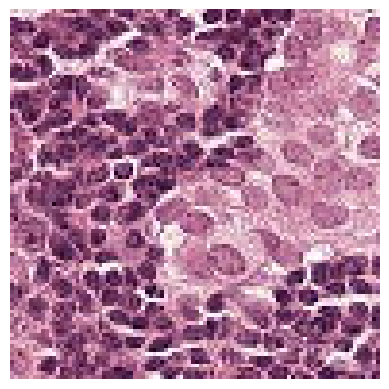

In [16]:
image_path = f'histo_data/test/{test_ids[0]}'
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [17]:
print('Image shape:')
np.array(img).shape

Image shape:


(96, 96, 3)

The images are 96x96 and 3 channels

## Exploratory Data Analysis

First, let's see the target distribution, in order to see if we have an imbalanced problem.

In [18]:
train_labels['label'].value_counts() / len(train_labels)

label
0    0.594969
1    0.405031
Name: count, dtype: float64

In [19]:
import seaborn as sns

/tmp/ipykernel_32638/2678351074.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_labels, x='label', palette="Set2")


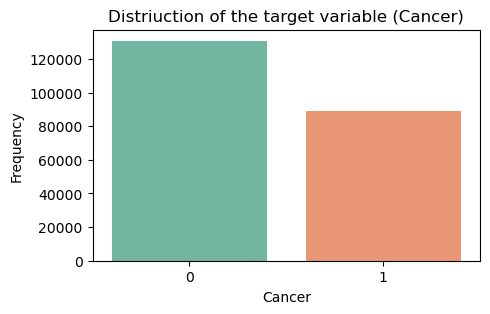

In [20]:
plt.figure(figsize=(5,3))
sns.countplot(data=train_labels, x='label', palette="Set2")

plt.xlabel("Cancer")
plt.ylabel("Frequency")
plt.title("Distriuction of the target variable (Cancer)")
plt.show()

The target is a little bit imbalanced as we have fewer cancer images, so we need to take care of this in the processing step

Now I'll take a look at the images between cancer vs non-cancer.

In [21]:
cancer_sample_images = train_labels[train_labels['label'] == 1].sample(9)['id'].values
non_cancer_sample_images = train_labels[train_labels['label'] == 0].sample(9)['id'].values

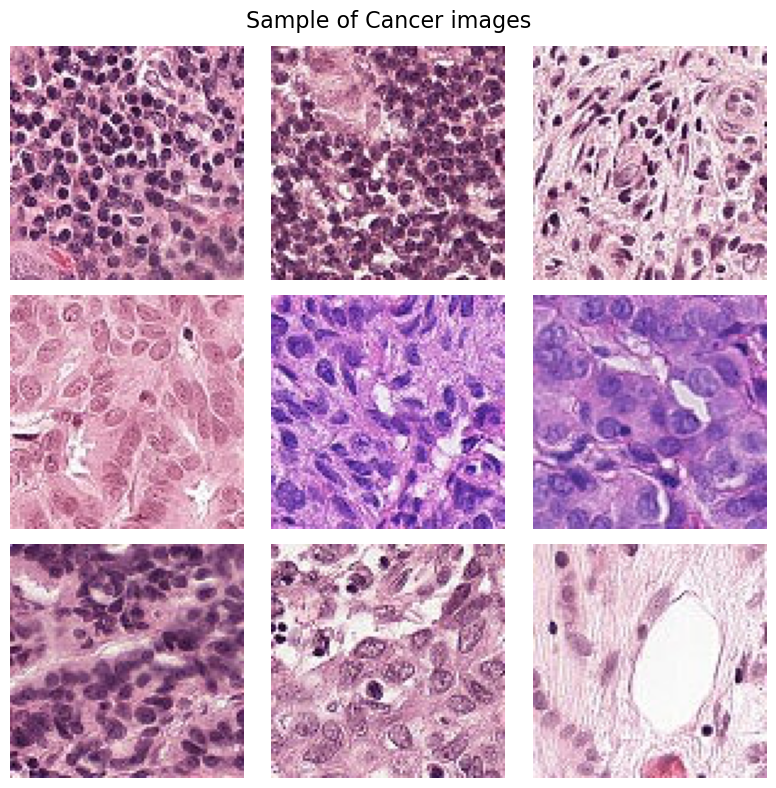

In [22]:
plt.figure(figsize=(8, 8))

for i, img_name in enumerate(cancer_sample_images):
    img_path = f'histo_data/train/{img_name}.tif'
    img = Image.open(img_path)
    
    plt.subplot(3, 3, i+1)  # 3x3 grid
    plt.imshow(img)
    plt.axis('off')

plt.suptitle('Sample of Cancer images', fontsize=16)
plt.tight_layout()
plt.show()

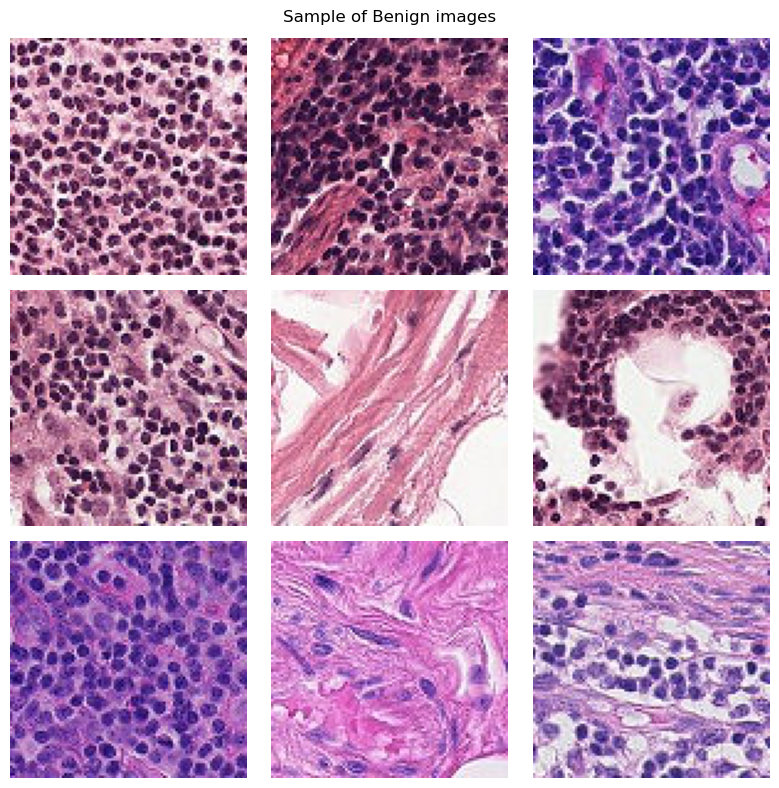

In [23]:
plt.figure(figsize=(8, 8))

for i, img_name in enumerate(non_cancer_sample_images):
    img_path = f'histo_data/train/{img_name}.tif'
    img = Image.open(img_path)
    
    plt.subplot(3, 3, i+1)  # 3x3 grid
    plt.imshow(img)
    plt.axis('off')

plt.suptitle('Sample of Benign images')
plt.tight_layout()
plt.show()

It's interesting to see that the cancer images looks that the cells follow a more irregular patron compared to the benign ones, and they are bigger.

Based on the EDA I'll do the following:
- Sample the data to balance the classes
- Normalize the images to have a more stable traing process
- Use only a fraction of training samples, to speed up the training
- Use data augmentations techniques, this is typicaly done in computer vision problems

### Data preparation
In this section I'll partition the data, use the data augmentation techniques, sample it, and so on.

In [70]:
train_labels['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

In [3]:
# Firts, let's sample the data to reduce it and balancing it.
sample_size = 80000
random_state = 102
train_labels_1 = train_labels[train_labels['label'] == 1].sample(
    int(sample_size/2), random_state=random_state)
train_labels_0 = train_labels[train_labels['label'] == 0].sample(
    int(sample_size/2), random_state=random_state)

In [4]:
train_labels_sample = pd.concat([train_labels_1, train_labels_0]).reset_index(drop=True)

In [5]:
train_labels_sample['label'].value_counts()

label
1    40000
0    40000
Name: count, dtype: int64

Now that we have a balanced data to train, let's prepare it.

In pytorch you need to create a class to load your data and prepare it for training

In [6]:
from torch.utils.data import Dataset, DataLoader, random_split

In [7]:
class TrainData(Dataset):
    def __init__(self, train_labels_sample, img_dir, transform=None):
        '''
        train_labels_sample: The training samples id's and their label.
        img_dir: the path in which the images are located.
        transform: The transformation to be applied to the images. (Resize, augmentation, normalization)
        '''
        self.data = train_labels_sample
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        ''' 
        This is the typical template in Pytorch, 
        it needs a __len__ method and __getitem__, to obtain the input and label
        based on index.
        '''
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0] + ".tif"
        label = int(self.data.iloc[idx, 1])
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, label


We can learn more about image transfornations in Pytorch in this link:
https://docs.pytorch.org/vision/0.22/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py

In [8]:
# 64x64
train_transforms = transforms.Compose([
    transforms.Resize((96,96)), # Resize the image to ensure that all have 96x96 shape
    transforms.RandomHorizontalFlip(), # Performs horizonal flip in image randomly
    transforms.RandomVerticalFlip(), # Performs vertical flip in image randomly
    transforms.RandomRotation(20), # Rotates the image randomly between (-20, 20) degrees
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2, 
        saturation=0.2, hue=0.05), # transform randomly changes the brightness, contrast, saturation, hue
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

# This is for validation/testing data, as it doesn't require to do the part 
# of data augmentation
val_transforms = transforms.Compose([
    transforms.Resize((96,96)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

In [9]:
dataset = TrainData(train_labels_sample, img_dir="histo_data/train", transform=train_transforms)

#### Train, validation split

In [10]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# For the validation data only use the parte that normalizes and resize the images, not the augmentation
val_dataset.dataset.transform = val_transforms

In [11]:
print('Train data size:')
print(len(train_dataset))
print('Validation data size:')
print(len(val_dataset))

Train data size:
64000
Validation data size:
16000


In [12]:

# This is one of the hyperparameters, it controls the batch size in which the data will be partitioned
batch_size = 32
# Now, let's pass each dataset to a DataLoader Pytorch class, this is in charge
# of suffling, creating the batch, and can do many other things.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



images, labels = next(iter(train_loader))
print(f"Train batch images: {images.shape}, labels: {labels.shape}")

images, labels = next(iter(val_loader))
print(f"Validation batch images: {images.shape}, labels: {labels.shape}")


Train batch images: torch.Size([32, 3, 96, 96]), labels: torch.Size([32])
Validation batch images: torch.Size([32, 3, 96, 96]), labels: torch.Size([32])


### Model architecture

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

Firts, I'll use this simple model architecture in order to see how it performs.
The architecture is a typical one, except that it has normalization in each layer
and max pooling.

It's simpler than VGNet, as it applies pooling after ecah Convolution, not two.


In [28]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolution 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        # 32 is the number of filters, and kernel size the filter size
        self.bn1 = nn.BatchNorm2d(32)
        
        # Convolution 2
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Convolution 3
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected
        self.fc1 = nn.Linear(128 * 12 * 12, 256)  # 96x96 -> 3 poolings => 12x12
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 1)  # 1 for binary classification

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 96x96 -> 48x48
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 48x48 -> 24x24
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # 24x24 -> 12x12
        x = x.view(-1, 128 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x  # Whithout sigmoid becase we'll use BCEWithLogitsLoss


Now, let's try a more complicated architure, in which I'll try 2 convolutions, then
a MaxPooling and a Dropout for trying to reduxe overfitting. And this will be repeated 3 times, so, 3 blocks and finally a fully conected layer.

I'll use ReLU as activation function for all the layers, as it works well in this type of problems.
and 3x3 filters (kernel size).

In [29]:
class CNNAdvanced(nn.Module):
    def __init__(self):
        super(CNNAdvanced, self).__init__()

        # First block
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4)
        )

        # Second block
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4)
        )

        # Third block
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4)
        )

        # Fully connected layer
        # height and weight size after 3 pools: 12x12
        # that's because we have 3 blocks, and each block has a MaxPool of (2,2): 96 -> 48 -> 24 -> 12
        self.flatten_dim = 128 * 12 * 12
        # And note that 128 is the depth size of the 3 block
        self.fc = nn.Sequential(
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)  # 1 for binary classification
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = x.view(-1, self.flatten_dim)  # flatten
        x = self.fc(x)
        return x # Whithout sigmoid becase we'll use BCEWithLogitsLoss

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simple_model = SimpleCNN().to(device)
print('Simple model architecture:')
print(simple_model)
print('*'*100)



Simple model architecture:
SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18432, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)
****************************************************************************************************


In [31]:
print('Advanced model architecture:')
advanced_model = CNNAdvanced().to(device)
print(advanced_model)

Advanced model architecture:
CNNAdvanced(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.4, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.4, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Re

#### Optimizer and Loss function

In [32]:
import torch.optim as optim
# For binarry classifier, and as I mentioned earlier, this function applies sigmoid while evaluationg the Loss.
loss_function_simple_model = nn.BCEWithLogitsLoss()
loss_function_advanced_model= nn.BCEWithLogitsLoss() 


# I'll use the Adam optimizer because is good optimization method.
optimizer_simple_model = optim.Adam(simple_model.parameters(), lr=0.0001)
optimizer_advanced_model = optim.Adam(advanced_model.parameters(), lr=0.0001)

##### Scheduler
This is for adjusting the learning reate after each epoch, in order to obtain better results, as it can happen that the parameters are arriving to an optimal value and the learning rate needs to be reduced.

In [33]:
scheduler_simple_model = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_simple_model, mode='max', factor=0.5, patience=2, min_lr=1e-5
)

scheduler_advanced_model = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_advanced_model, mode='max', factor=0.5, patience=2, min_lr=1e-5
)

# Training
In order to see the performance after each epoch I'll use the following metrics:
- Accuracy
- AUC: This is a good metric for binary classification models, as it does't depend on threshold, so it's more robust.

In [20]:
from sklearn.metrics import roc_auc_score

def training_model(num_epochs, optimizer, model, loss_function, scheduler, model_save_path):
    # This is the value to store the best validation AUC and save the best model
    best_val_auc = -1.0
    # Iterate all the data in each epoch
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        # In this part, it iterates over each batch
        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)

            # Set gradients to zero, because Pytorch acumulates the previous ones.
            optimizer.zero_grad()
            outputs = model(images)
            # calculate the loss
            loss = loss_function(outputs, labels)
            # Calculate the gradients respect to the loss
            loss.backward()
            # Finally update the parameters based on the gradients calculated with loss.backward()
            optimizer.step()

            # Calculate the loss
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        # here I'll save the labels and prediction for each batch in the validation set
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
                outputs = model(images)
                loss = loss_function(outputs, labels)
                val_loss += loss.item() * images.size(0)
                
                probs = torch.sigmoid(outputs)
                preds = probs >= 0.5
                correct += (preds.float() == labels).sum().item()
                
                all_labels.append(labels.cpu())
                all_probs.append(probs.cpu())

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct / len(val_loader.dataset)

        # Concat for all the batches
        all_labels = torch.cat(all_labels).numpy()
        all_probs = torch.cat(all_probs).numpy()
        val_auc = roc_auc_score(all_labels, all_probs)

        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}")
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            # Save the best model parameters
            torch.save(model.state_dict(), model_save_path)
            print(f"Best model saved with validation AUC: {best_val_auc:.4f}")

        # Update the learning rate with the scheduler
        scheduler.step(val_auc) # Based on AUC, maximize the AUC



Now, lets train the first simple model

In [34]:
training_model(
    num_epochs=15, optimizer=optimizer_simple_model,
    model=simple_model, loss_function=loss_function_simple_model,
    scheduler=scheduler_simple_model,
    model_save_path='models/best_simple_cnn_model.pth')

Epoch 1/15, Training Loss: 0.4367
Validation Loss: 0.3658, Accuracy: 0.8368, AUC: 0.9179
Best model saved with validation AUC: 0.9179
Epoch 2/15, Training Loss: 0.3809
Validation Loss: 0.3382, Accuracy: 0.8577, AUC: 0.9310
Best model saved with validation AUC: 0.9310
Epoch 3/15, Training Loss: 0.3594
Validation Loss: 0.3457, Accuracy: 0.8446, AUC: 0.9301
Epoch 4/15, Training Loss: 0.3362
Validation Loss: 0.3409, Accuracy: 0.8556, AUC: 0.9416
Best model saved with validation AUC: 0.9416
Epoch 5/15, Training Loss: 0.3239
Validation Loss: 0.3017, Accuracy: 0.8694, AUC: 0.9461
Best model saved with validation AUC: 0.9461
Epoch 6/15, Training Loss: 0.3112
Validation Loss: 0.3129, Accuracy: 0.8694, AUC: 0.9495
Best model saved with validation AUC: 0.9495
Epoch 7/15, Training Loss: 0.3004
Validation Loss: 0.2854, Accuracy: 0.8774, AUC: 0.9511
Best model saved with validation AUC: 0.9511
Epoch 8/15, Training Loss: 0.2863
Validation Loss: 0.2732, Accuracy: 0.8846, AUC: 0.9550
Best model saved w

Let's load the best simple model

In [56]:
simple_model = SimpleCNN().to(device)
simple_model.load_state_dict(torch.load("models/best_simple_cnn_model.pth"))

<All keys matched successfully>

Let's plot the train and validation AUC

In [49]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [53]:
def calculate_probability_of_cancer(model, data_loader):
    '''
    Model: The model to calculate the probability
    data_loader: The data batches, train or validation
    '''
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            # This is necessesary because the model outputs the raw after 
            # the conected layer, no the probability
            probs = torch.sigmoid(outputs)
            all_labels.append(labels.cpu())
            all_probs.append(probs.cpu())
    all_labels = torch.cat(all_labels).numpy()
    all_probs = torch.cat(all_probs).numpy()
    return all_labels, all_probs

In [57]:
train_labels, train_probs = calculate_probability_of_cancer(
    simple_model, train_loader)
val_labels, val_probs = calculate_probability_of_cancer(
    simple_model, val_loader)

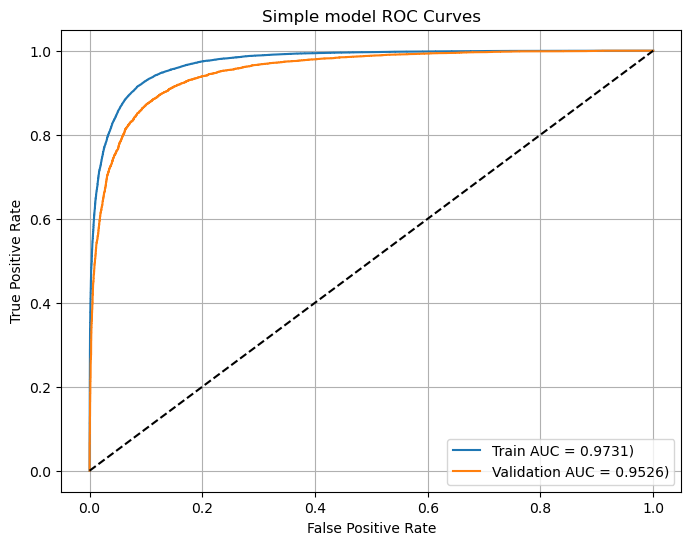

In [58]:
train_fpr, train_tpr, _ = roc_curve(train_labels, train_probs)
val_fpr, val_tpr, _ = roc_curve(val_labels, val_probs)

train_auc = auc(train_fpr, train_tpr)
val_auc = auc(val_fpr, val_tpr)

# Plot the AUC
plt.figure(figsize=(8,6))
plt.plot(train_fpr, train_tpr, label=f'Train AUC = {train_auc:.4f})')
plt.plot(val_fpr, val_tpr, label=f'Validation AUC = {val_auc:.4f})')
plt.plot([0,1], [0,1], 'k--')  # diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Simple model ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

For me looks a good model as it doesn't overfit in the training data compared to the validation set, and also has a great AUC.

But let's check with the advanced model archirecture.

Training the advanced model architecture

In [42]:
training_model(
    num_epochs=15, optimizer=optimizer_advanced_model,
    model=advanced_model, loss_function=loss_function_advanced_model,
    scheduler=scheduler_advanced_model,
    model_save_path='models/best_advanced_cnn_model.pth')

Epoch 1/15, Training Loss: 0.4458
Validation Loss: 0.3703, Accuracy: 0.8363, AUC: 0.9163
Best model saved with validation AUC: 0.9163
Epoch 2/15, Training Loss: 0.3708
Validation Loss: 0.3439, Accuracy: 0.8542, AUC: 0.9283
Best model saved with validation AUC: 0.9283
Epoch 3/15, Training Loss: 0.3486
Validation Loss: 0.3546, Accuracy: 0.8461, AUC: 0.9357
Best model saved with validation AUC: 0.9357
Epoch 4/15, Training Loss: 0.3250
Validation Loss: 0.2963, Accuracy: 0.8742, AUC: 0.9467
Best model saved with validation AUC: 0.9467
Epoch 5/15, Training Loss: 0.3048
Validation Loss: 0.3136, Accuracy: 0.8643, AUC: 0.9482
Best model saved with validation AUC: 0.9482
Epoch 6/15, Training Loss: 0.2884
Validation Loss: 0.2748, Accuracy: 0.8847, AUC: 0.9556
Best model saved with validation AUC: 0.9556
Epoch 7/15, Training Loss: 0.2745
Validation Loss: 0.2609, Accuracy: 0.8912, AUC: 0.9588
Best model saved with validation AUC: 0.9588
Epoch 8/15, Training Loss: 0.2620
Validation Loss: 0.2619, Acc

Load the best advanced model

In [44]:
advanced_model = CNNAdvanced().to(device)
advanced_model.load_state_dict(torch.load("models/best_advanced_cnn_model.pth"))

<All keys matched successfully>

In [47]:
train_labels, train_probs = calculate_probability_of_cancer(
    advanced_model, train_loader)
val_labels, val_probs = calculate_probability_of_cancer(
    advanced_model, val_loader)

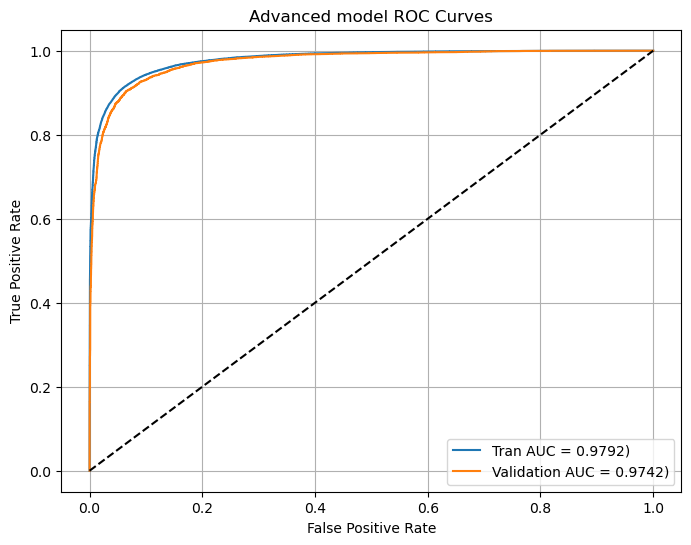

In [50]:
train_fpr, train_tpr, _ = roc_curve(train_labels, train_probs)
val_fpr, val_tpr, _ = roc_curve(val_labels, val_probs)

train_auc = auc(train_fpr, train_tpr)
val_auc = auc(val_fpr, val_tpr)

# Plot the AUC
plt.figure(figsize=(8,6))
plt.plot(train_fpr, train_tpr, label=f'Tran AUC = {train_auc:.4f})')
plt.plot(val_fpr, val_tpr, label=f'Validation AUC = {val_auc:.4f})')
plt.plot([0,1], [0,1], 'k--')  # diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Advanced model ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

This model looks better in the following terms:
- More validation AUC
- Less discrepancy between train/val AUC

So, I'll choose the advanced architecture to do parameter tuning.

# Hyperparameter tuning
Here, I'll use the simpler model architecture and tune the following hyperparameters:
- Dropout propotion
- Learning rate
- Depth in each convolution layer
- Units in the fully conected layer, the last one to prediction


I'll be using optuna is an open-source Python library designed for automatic hyperparameter optimization.
You can learn more about Optuna here: 
https://optuna.readthedocs.io/en/stable/

In [61]:
import optuna

In [67]:
def objective(trial):

    # Hyperparameter space
    first_filters = trial.suggest_categorical('first_filters', [16, 32, 64])
    second_filters = trial.suggest_categorical('second_filters', [32, 64, 128])
    third_filters = trial.suggest_categorical('third_filters', [64, 128, 256])
    fc1_units = trial.suggest_categorical('fc1_units', [128, 256, 512])
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.6)
    dropout_rate_fc_layer = trial.suggest_float('dropout_rate_fc_layer', 0.3, 0.6)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)

    # Model definition based on hyperparameters
    class TunedCNN(nn.Module):
        def __init__(self):
            super(TunedCNN, self).__init__()

            # First block
            self.block1 = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=first_filters, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(first_filters, first_filters, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(first_filters, first_filters, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
                nn.Dropout(dropout_rate)
            )

            # Second block
            self.block2 = nn.Sequential(
                nn.Conv2d(first_filters, second_filters, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(second_filters, second_filters, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(second_filters, second_filters, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
                nn.Dropout(dropout_rate)
            )

            # Third block
            self.block3 = nn.Sequential(
                nn.Conv2d(second_filters, third_filters, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(third_filters, third_filters, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(third_filters, third_filters, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
                nn.Dropout(dropout_rate)
            )

            # Fully connected layer
            # height and weight size after 3 pools: 12x12
            # that's because we have 3 blocks, and each block has a MaxPool of (2,2): 96 -> 48 -> 24 -> 12
            self.flatten_dim = third_filters * 12 * 12
            self.fc = nn.Sequential(
                nn.Linear(self.flatten_dim, fc1_units),
                nn.ReLU(),
                nn.Dropout(dropout_rate_fc_layer),
                nn.Linear(fc1_units, 1)  # 1 for binary classification
            )

        def forward(self, x):
            x = self.block1(x)
            x = self.block2(x)
            x = self.block3(x)
            x = x.view(-1, self.flatten_dim)  # flatten
            x = self.fc(x)
            return x # Whithout sigmoid becase we'll use BCEWithLogitsLoss
    
    # Define the model, loss and optimizer
    model = TunedCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()

    # Training the model with only 3 epochs
    for epoch in range(3):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation set
    # Here we calculate the AUC in validation after the 3 epochs
    model.eval()
    all_labels, all_probs = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            all_labels.append(labels.cpu())
            all_probs.append(probs.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_probs = torch.cat(all_probs).numpy()
    val_auc = roc_auc_score(all_labels, all_probs)

    return val_auc  # Maximize AUC


In [68]:
# Use optuna for hyperparameter tuning
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2025-10-19 17:12:32,092] A new study created in memory with name: no-name-183a94c5-2fcd-4a0d-b6c8-1c8a5b6d4eed
[I 2025-10-19 17:14:42,183] Trial 0 finished with value: 0.9480223296142053 and parameters: {'first_filters': 32, 'second_filters': 32, 'third_filters': 64, 'fc1_units': 256, 'dropout_rate': 0.3573645125609611, 'dropout_rate_fc_layer': 0.5003182849929355, 'lr': 0.0007535852928427284}. Best is trial 0 with value: 0.9480223296142053.
[I 2025-10-19 17:16:53,921] Trial 1 finished with value: 0.9487169184569781 and parameters: {'first_filters': 64, 'second_filters': 128, 'third_filters': 128, 'fc1_units': 128, 'dropout_rate': 0.463330331906297, 'dropout_rate_fc_layer': 0.4243118924853174, 'lr': 0.00044517510543163415}. Best is trial 1 with value: 0.9487169184569781.
[I 2025-10-19 17:19:05,458] Trial 2 finished with value: 0.5 and parameters: {'first_filters': 64, 'second_filters': 64, 'third_filters': 128, 'fc1_units': 128, 'dropout_rate': 0.41367664367883394, 'dropout_rate_fc_l

We can see that there are hyperparameters combinations that doesn't work well, so the valid AUC is 0.5

In [71]:
print("Best hyperparameters:", study.best_params)
print("Best AUC:", study.best_value)

Best hyperparameters: {'first_filters': 64, 'second_filters': 32, 'third_filters': 64, 'fc1_units': 256, 'dropout_rate': 0.5106408629195538, 'dropout_rate_fc_layer': 0.4776451070371182, 'lr': 0.00034503462288880974}
Best AUC: 0.9572416487625764


Now that we have the best hyperparameters, let's define the model architecture with those and train it with more epochs.

In [72]:
class TunedCNN(nn.Module):
    def __init__(self):
        super(TunedCNN, self).__init__()

        # First block
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5106408629195538)
        )

        # Second block
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5106408629195538)
        )

        # Third block
        self.block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5106408629195538)
        )

        # Fully connected layer
        # height and weight size after 3 pools: 12x12
        # that's because we have 3 blocks, and each block has a MaxPool of (2,2): 96 -> 48 -> 24 -> 12
        self.flatten_dim = 64 * 12 * 12
        # And note that 128 is the depth size of the 3 block
        self.fc = nn.Sequential(
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4776451070371182),
            nn.Linear(256, 1)  # 1 for binary classification
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = x.view(-1, self.flatten_dim)  # flatten
        x = self.fc(x)
        return x # Whithout sigmoid becase we'll use BCEWithLogitsLoss
# Define the model, loss and optimizer
model_tunned = TunedCNN().to(device)
optimizer = optim.Adam(model_tunned.parameters(), lr=0.00034503462288880974)
loss_fn = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2, min_lr=1e-5
)


In [73]:
training_model(
    num_epochs=15, optimizer=optimizer,
    model=model_tunned, loss_function=loss_fn,
    scheduler=scheduler,
    model_save_path='models/best_tuned_cnn_model.pth')

Epoch 1/15, Training Loss: 0.4814
Validation Loss: 0.3993, Accuracy: 0.8242, AUC: 0.9070
Best model saved with validation AUC: 0.9070
Epoch 2/15, Training Loss: 0.3711
Validation Loss: 0.3175, Accuracy: 0.8631, AUC: 0.9392
Best model saved with validation AUC: 0.9392
Epoch 3/15, Training Loss: 0.3190
Validation Loss: 0.2854, Accuracy: 0.8816, AUC: 0.9526
Best model saved with validation AUC: 0.9526
Epoch 4/15, Training Loss: 0.2832
Validation Loss: 0.2674, Accuracy: 0.8892, AUC: 0.9574
Best model saved with validation AUC: 0.9574
Epoch 5/15, Training Loss: 0.2606
Validation Loss: 0.2386, Accuracy: 0.9014, AUC: 0.9663
Best model saved with validation AUC: 0.9663
Epoch 6/15, Training Loss: 0.2412
Validation Loss: 0.2539, Accuracy: 0.8983, AUC: 0.9689
Best model saved with validation AUC: 0.9689
Epoch 7/15, Training Loss: 0.2297
Validation Loss: 0.2437, Accuracy: 0.9013, AUC: 0.9719
Best model saved with validation AUC: 0.9719
Epoch 8/15, Training Loss: 0.2208
Validation Loss: 0.2319, Acc

Let's load the best tuned model

In [74]:
model_tunned = TunedCNN().to(device)
model_tunned.load_state_dict(torch.load("models/best_tuned_cnn_model.pth"))

<All keys matched successfully>

In [75]:
train_labels, train_probs = calculate_probability_of_cancer(
    model_tunned, train_loader)
val_labels, val_probs = calculate_probability_of_cancer(
    model_tunned, val_loader)

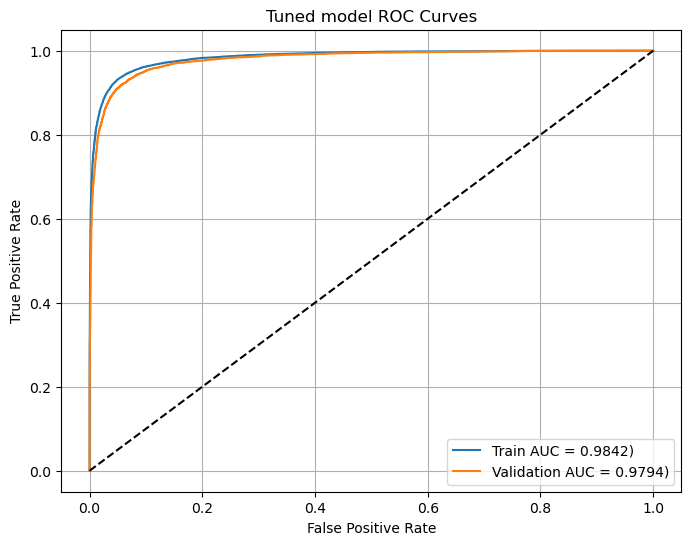

In [76]:
train_fpr, train_tpr, _ = roc_curve(train_labels, train_probs)
val_fpr, val_tpr, _ = roc_curve(val_labels, val_probs)

train_auc = auc(train_fpr, train_tpr)
val_auc = auc(val_fpr, val_tpr)

# Plot the AUC
plt.figure(figsize=(8,6))
plt.plot(train_fpr, train_tpr, label=f'Train AUC = {train_auc:.4f})')
plt.plot(val_fpr, val_tpr, label=f'Validation AUC = {val_auc:.4f})')
plt.plot([0,1], [0,1], 'k--')  # diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned model ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

# Test data for leaderboard
Now, let's predict the probability for the test data

In [35]:
from torch.utils.data import Dataset

First, we need to upload the data and prepare to ingest it to the model

In [39]:

# we need to create a custom class with the same template of Training data, but this is simpler.
class TestDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_files = os.listdir(folder_path)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.folder_path, img_name)
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, img_name

# The tranfsomation for the test, is equal to the validation set.
test_transforms = transforms.Compose([
    transforms.Resize((96,96)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

test_dataset = TestDataset("histo_data/test", transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Now, evaluate with each model

In [40]:
def obtain_test_predictions(model):
    model.eval()
    predictions = []

    with torch.no_grad():
        # Iterate over the batches
        for images, file_names in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy()  # Apply the sigmoid for convert to probability

            # save each probability sample in the batch
            for fname, prob in zip(file_names, probs):
                predictions.append((fname, prob[0]))
    return predictions

##### Simple model

In [41]:
predictions_simple_model = obtain_test_predictions(simple_model)
submission_simple_model = pd.DataFrame(predictions_simple_model, columns=['id', 'label'])

submission_simple_model['id'] = submission_simple_model['id'].str.replace('.tif', '')
submission_simple_model.to_csv("submission_simple_model.csv", index=False)


##### Advanced model

In [51]:
predictions_advanced_model = obtain_test_predictions(advanced_model)
submission_advanced_model = pd.DataFrame(predictions_advanced_model, columns=['id', 'label'])

submission_advanced_model['id'] = submission_advanced_model['id'].str.replace('.tif', '')
submission_advanced_model.to_csv("submission_advanced_model.csv", index=False)


Tuned model

In [77]:
predictions_tunned_model = obtain_test_predictions(model_tunned)
submission_tunned_model = pd.DataFrame(predictions_tunned_model, columns=['id', 'label'])

submission_tunned_model['id'] = submission_tunned_model['id'].str.replace('.tif', '')
submission_tunned_model.to_csv("submission_tunned_model.csv", index=False)

After passing the test set in LeaderBoard at Kaggle I obtained the following public and private scores:
- Simple model:
    - Public score: 0.9296
    - Private score: 0.8934
- Advanced model:
    - Public score: 0.9463
    - Private score: 0.9181
- Tuned model:
    - Public score: 0.9503
    - Private score: 0.9105

# Conclusion
- Is better using an advanced architecture for this problem than a simpler one
- The model with hyperparameter tuning is better in public score but worse in private score
- The best model in leaderboard is: The advanced model but without hyperparameter tuning
- I didn't showd this, but at the beginning I started resizing the images from 96x96 to 64x64, and the training time is almost the same, but the performance is better using 96x96. I think that using more resolution allows the model to learn finer details in images.


# Next steps:
- Optimize the architecture, trying to adjust the trial function in Optuna to change the architecture
- I used 80,000 samples for train/validation, so, the next step is trying with more data
- Try more epochs in the hyperparameter optimization, rather than 3
- Try more n_trials, I used 20
